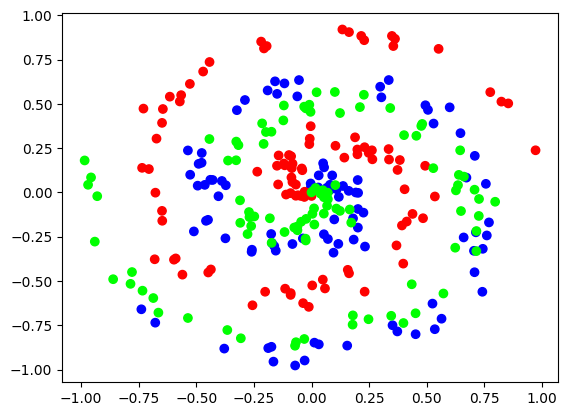

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs.datasets

X, y = nnfs.datasets.spiral_data(100, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg")
plt.show()

In [2]:
class L1_L2_Regularization:
    def __init__(
        self,
        n_inputs,
        n_nueorns,
        weigth_regularizer_l1=0,
        bias_regularizer_l1=0,
        weigth_regularizer_l2=0,
        bias_regularizer_l2=0,
    ):
        self.weigths = 0.01 * np.random.randn(n_inputs, n_nueorns)
        self.biases = np.zeros((1, n_nueorns))
        self.weigth_regularizer_l1 = weigth_regularizer_l1
        self.weigth_regularizer_l2 = weigth_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs) -> np.array:
        self.inputs = inputs
        self.outputs = np.dot(inputs, self.weigths) + self.biases

    def backward(self, dvalues):
        self.dweigths = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        if self.weigth_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weigths)
            dL1[self.weigths < 0] = -1
            self.dweigths += self.weigth_regularizer_l1 * dL1

        if self.weigth_regularizer_l2 > 0:
            self.dweigths += 2 * self.weigth_regularizer_l2 * self.weigths

        if self.bias_regularizer_l1 > 0:
            dL2 = np.ones_like(self.biases)
            dL2[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL2

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        self.dinputs = np.dot(dvalues, self.weigths.T)

In [3]:
class Loss:
    def regularization_loss(self, layer):
        regularizer_loss = 0
        if layer.weigth_regularizer_l1 > 0:
            regularizer_loss += layer.weigth_regularizer_l1 * np.sum(
                np.abs(layer.weigths)
            )
        if layer.weigth_regularizer_l2 > 0:
            regularizer_loss += layer.weigth_regularizer_l2 * np.sum(
                layer.weigths * layer.weigths
            )
        if layer.bias_regularizer_l1 > 0:
            regularizer_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
        if layer.bias_regularizer_l2 > 0:
            regularizer_loss += layer.bias_regularizer_l2 * np.sum(
                layer.biases * layer.biases
            )
        return regularizer_loss

    def calculate(self, y_pred, y_true):
        loss = self.forward(y_pred, y_true)
        return np.mean(loss)

In [4]:
class ReLU:
    def forward(self, x):
        self.inputs = x
        self.outputs = np.maximum(0, x)

    def backward(self, dvalues: list):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [5]:

class SoftMax:
    def forward(self, inputs):
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob = exp_val / np.sum(exp_val, axis=1, keepdims=True)
        self.outputs = prob


class CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_clip = np.clip(y_pred, 1e-9, 1 - 1e-9)
        if len(y_true.shape) == 1:
            confidence_val = y_clip[
                range(len(y_pred)), y_true
            ]  ## for Sparse_categoricalCrossEntropy case
        else:
            confidence_val = np.sum(y_pred * y_true)  ## for Categorical Outputs
        return -np.log(confidence_val)

    def backward(self, dvalues, y_true):
        samples = len(y_true)
        labels = len(len(dvalues)[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


class SotMax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation = SoftMax()
        self.loss = CategoricalCrossEntropy()
        self.l1_l2_loss=Loss()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.outputs = self.activation.outputs
        return self.loss.calculate(self.outputs, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

## ADAM Optimizer

In [6]:
class Adam:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weigths)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.weight_cache = np.zeros_like(layer.weigths)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweigths
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweigths**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weigths += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


In [7]:
dense_1 = L1_L2_Regularization(
    X.shape[1], 50, weigth_regularizer_l1=5e-3, weigth_regularizer_l2=5e-3
)
activation_1 = ReLU()

dense_2 = L1_L2_Regularization(50, 3)
activation_2 = SotMax_Loss_CategoricalCrossEntropy()

optimizer = Adam(learning_rate=0.02, decay=1e-5)
for epoch in range(10001):
    dense_1.forward(X)
    activation_1.forward(dense_1.outputs)
    dense_2.forward(activation_1.outputs)
    loss_activation_2 = activation_2.forward(dense_2.outputs, y)
    loss = activation_2.loss.regularization_loss(
        dense_1
    ) + activation_2.loss.regularization_loss(dense_2)
    +loss_activation_2

    predictions = np.argmax(activation_2.outputs, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(
            f"epoch: {epoch}, "
            + f"acc: {accuracy:.3f}, "
            + f"loss: {loss:.3f}, "
            + f"lr: {optimizer.current_learning_rate}"
        )
    activation_2.backward(dense_2.outputs, y)
    dense_2.backward(activation_2.dinputs)

    activation_1.backward(dense_2.dinputs)
    dense_1.backward(activation_1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense_1)
    optimizer.update_params(dense_2)
    optimizer.post_update_params()

epoch: 0, acc: 0.317, loss: 0.004, lr: 0.02
epoch: 100, acc: 0.420, loss: 0.001, lr: 0.01998021958261321
epoch: 200, acc: 0.417, loss: 0.003, lr: 0.019960279044701046
epoch: 300, acc: 0.417, loss: 0.002, lr: 0.019940378268975763
epoch: 400, acc: 0.413, loss: 0.002, lr: 0.01992051713662487
epoch: 500, acc: 0.413, loss: 0.002, lr: 0.01990069552930875
epoch: 600, acc: 0.410, loss: 0.002, lr: 0.019880913329158343
epoch: 700, acc: 0.407, loss: 0.002, lr: 0.019861170418772778
epoch: 800, acc: 0.420, loss: 0.002, lr: 0.019841466681217078
epoch: 900, acc: 0.420, loss: 0.002, lr: 0.01982180200001982
epoch: 1000, acc: 0.413, loss: 0.002, lr: 0.019802176259170884
epoch: 1100, acc: 0.417, loss: 0.002, lr: 0.01978258934311912
epoch: 1200, acc: 0.413, loss: 0.002, lr: 0.01976304113677013
epoch: 1300, acc: 0.413, loss: 0.002, lr: 0.019743531525483964
epoch: 1400, acc: 0.423, loss: 0.002, lr: 0.01972406039507293
epoch: 1500, acc: 0.423, loss: 0.002, lr: 0.019704627631799327
epoch: 1600, acc: 0.423, lo

In [8]:
X_test, y_test = nnfs.datasets.spiral_data(100, 3)

In [9]:
dense_1.forward(X_test)
activation_1.forward(dense_1.outputs)

dense_2.forward(activation_1.outputs)
loss = activation_2.forward(dense_2.outputs, y_test)

predictions = np.argmax(activation_2.outputs, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print(
    f"acc: {accuracy:.3f}, "
    + f"loss: {loss:.3f}, "
)

acc: 0.450, loss: 1.082, 
